
# Training a Diffusion Model on Latent Representations

In previous tutorials, we trained diffusion models to generate small, domain-specific images like animal faces. While this was a good starting point, real-world applications often require generating larger, more diverse images.

This tutorial explores a more scalable approach by training on latent representations rather than raw pixels. We'll follow the [Stable Diffusion](https://github.com/CompVis/stable-diffusion) approach and build upon the [Transformer Latent Diffusion](https://github.com/apapiu/transformer_latent_diffusion) project by Alexandru Papiu, which efficiently handles high-resolution, diverse image generation by operating in a compressed latent space.

## Hardware Requirements and Considerations

Training large diffusion models requires significant computational resources. Let's examine some common GPU options available in cloud computing platforms.

The NVIDIA A10, A100, and H100 GPUs represent different performance tiers:

| GPU Model | VRAM Options | Performance Comparison | Cost (per hour)  |
|-----------|--------------|------------------------|------------------|
| A10       | 24GB         | Baseline               | $0.75            |
| A100      | 40GB, 80GB   | ~3x faster than A10    | $1.79            |
| H100      | 40GB, 80GB   | ~2x faster than A100   | $2.99            |

The A10 offers a cost-effective entry point with 24GB VRAM. The A100 and H100 both come in 40GB and 80GB variants, providing substantially more memory and computing power. The A100 performs about 3 times faster than the A10, while the H100 delivers roughly twice the performance of an A100.

These prices reflect [Lambda Cloud](https://lambda.ai/service/gpu-cloud#pricing)'s on-demand pricing for instances (as of Feb 2025). While the H100 has the highest hourly cost, its superior performance makes it the most efficient choice when considering total compute cost needed for training.

## Inpsecting the Dataset: the Latents from MidJourney Images

In [2]:
# Load the Latents
# Run this only once.
%cd ..

import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
from nanodiffusion.datasets import MJLatentsDataset

ds = MJLatentsDataset()


/home/ubuntu/.local/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/home/ubuntu/zz/nano-diffusion
File data/raw/mj_latents.npy already exists. Skipping download.
File data/raw/mj_text_emb.npy already exists. Skipping download.


In [3]:
# Print out the first example
for k, v in ds[0].items():
    print(k, v.shape)

image_emb (4, 32, 32)
text_emb (768,)


Each training example has one latent image `image_emb` that has 4 channels and 32x32 resolution, and a text embedding `text_emb` which is a 768 dimensional vector.

What does the actual image look like? Let's decode `image_emb` back to the image space.

In [28]:
# Load VAE
import torch
from diffusers import AutoencoderKL

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float32).to(device)
_ = vae.eval()

In [29]:
with torch.no_grad():
    latent = torch.asarray(ds[2]["image_emb"]).unsqueeze(0).float().to(device)
    print("latent vector:", latent.shape)
    img = vae.decode(latent).sample
    img = img.to(device).cpu().permute(0, 2, 3, 1).numpy()
    print("image:", img.shape)

latent vector: torch.Size([1, 4, 32, 32])
image: (1, 256, 256, 3)


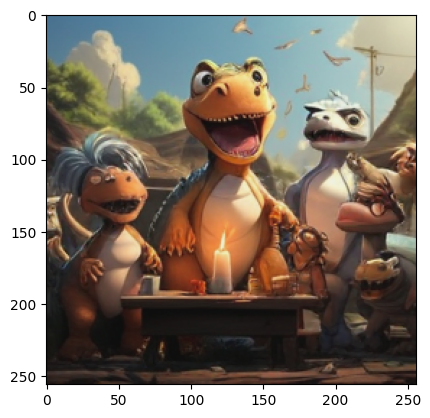

In [30]:
img = (img - img.min()) / (img.max() - img.min()) * 255
img = img.astype(np.uint8)
plt.imshow(img[0])
plt.show()

What a cute gathering of cartoon dinos.

During training, we only need the latents. So don't need to directly use these images.

## An Improved Diffusion Algorithm: VDM

We are going to create a [variant](https://github.com/apapiu/transformer_latent_diffusion) of the standard diffusion algorithm based on [Variational Diffusion Models (VDM)](https://arxiv.org/pdf/2107.00630).

### Forward Diffusion in VDM

In forward diffusion, a simpler formula is used (notice the absence square root):

$$\mathbf{x}_t = (1-\sigma_t) \cdot \mathbf{x}_0 + \sigma_t \mathbf{\epsilon}
$$

where $\sigma_t$ is noise level, and $\mathbf{\epsilon}$ is a noise sample from a standard normal distribution.

### Reverse Diffusion in VDM

In reverse diffusion, we first predict the clean image $\mathbf{\hat{x}}_0$ from the noisy image $\mathbf{x}_t$, and then apply forward diffusion to get the less noisy image $\mathbf{x}_{t-1}$ in the previous noise level:

$$\mathbf{x}_{t-1} = (1 - \frac{\sigma_{t-1}}{\sigma_{t}}) \cdot \mathbf{\hat{x}}_0 + \frac{\sigma_{t-1}}{\sigma_{t}} \cdot \mathbf{x}_{t}
$$

where $\mathbf{\hat{x}}_0$ is the predicted clean image from the denoising model $f_\theta(x_t, t)$. Here the denoising model no longer predicts the noise, but the clean image. This simplifies the parameterization.

### A Faster Sampling Method: DDPM+

An improved sampling method, DDPM+, uses a combination of the current and previous predictions to get better estimates:

$$
x_{t-1} = \frac{(\sigma_t - \sigma_{t-1})}{\sigma_t} D_t + \frac{\sigma_{t-1}}{\sigma_t} x_t
$$

Here $D_t$ is a combination of the current and previous predictions:

$$
D_t =  f_\theta(x_t, t) + \frac{1}{2r_t} \left( f_\theta(x_t, t) - f_\theta(x_{t+1}, t+1) \right)
$$

where $r_t$ is the ratio of consecutive step sizes in log-SNR space:

$$
r_t = \frac{h_t}{h_{t+1}} = \frac{\log(\sigma_t/\sigma_{t-1})}{\log(\sigma_{t+1}/\sigma_t)}
$$

This is essentially a form of multistep method that uses information from multiple timesteps to get better estimates, similar to how higher-order numerical methods work.

**With above improvements, much fewer steps (e.g. 40 instead of 1000) are needed to generate high-quality images.**

### Conditional Generation

For conditional generation, the classifier-free guidance is applied on the predicted clean image $\mathbf{\hat{x}}_0$:

$$
\mathbf{\hat{x}}_0 = s \cdot \mathbf{\hat{x}}_0^{\textrm{cond}} + (1-s) \cdot \mathbf{\hat{x}}_0^{\textrm{uncond}}
$$

where $\mathbf{\hat{x}}_0^{\textrm{cond}}$ is the predicted clean image from the denoising model with the text prompt, and $\mathbf{\hat{x}}_0^{\textrm{uncond}}$ is the predicted clean image from the denoising model without the text prompt, and $s$ is the guidance scale.

## Transformer based denoising model

Transformer architecture is an increasingly popular architecture for denoising models. Its benefits include:

- Flexibility Across Modalities: The inherent design of transformers allows them to be adapted across various data types with minimal modifications. This flexibility is advantageous in denoising applications that may involve different modalities, such as images, text, or audio. U-Net architectures, being convolution-based, are primarily tailored for spatial data and may require significant adjustments to handle other modalities effectively.
- Global Context Modeling: Transformers use self-attention to capture long-range dependencies across the entire input, providing better understanding of global image context for denoising. U-Nets, being convolutional, primarily focus on local features and may struggle with distant relationships.
- Scalability: Transformers process all elements simultaneously, enabling efficient parallel computation and better scaling for high-resolution images. Although the quadratic complexity of attention layers increases memory usage and compute time. U-Nets may face scaling limitations due to their hierarchical convolutional structure.

We use a model architecture from the [tld](https://github.com/apapiu/transformer_latent_diffusion) project. It is inspired by DiT and Pixart-Alpha.
 To address the "patchy" outputs common with Transformers processing spatial data, the model incorporates a depth-wise convolution in the FFN layer (borrowed from the Local ViT paper).
 
For encoding, the model:

- Processes 4×32×32 image latent inputs using a patch size of 2, creating 256 flattened 16-dimensional "pixels"
- Uses simple conditioning by concatenating a 768-dimensional pooled CLIP text embedding (ViT/L14) with sinusoidal noise embedding
- Feeds this combined conditioning through cross-attention layers in each transformer block

## Codebase Improvements

We will add some readability improvements to the codebase. In `notebooks/lib_5`, you can find the improved codebase. Here are some notable changes:


### 1. `BaseDiffusionAlgorithm` class

To consolidate the different diffusion algorithms, we introduce a `BaseDiffusionAlgorithm` class that contains the common logic for all diffusion algorithms. We will then extend this class to implement `DDPM` (`notebooks/lib_5/ddpm.py`), `VDM` (`notebooks/lib_5/vdm.py`). Even flow matching can be implemented as a subclass of `BaseDiffusionAlgorithm`. This way, you can easily switch between different diffusion algorithms, without changing the model architecture, the VAE, or the training loop.

This abstraction exposes 2 methods:

- `prepare_training_examples`: Prepare a training example for the denoising model by adding noise to the input data. This is the forward diffusion process, i.e. the teaching.
- `sample`: Sample from the denoising model. For diffusion, this is the reverse diffusion process. This is the generation process using a learned denoising model.

```python
class BaseDiffusionAlgorithm:
    """
    A common interface for diffusion algorithms.
    """
    def prepare_training_examples(self, batch: MiniBatch, **kwargs) -> Tuple[Dict[str, torch.Tensor], torch.Tensor]:
        """
        Prepare a training example for the denoising model by adding noise to the input data.

        This is used in the training step.

        For diffusion, this is the forward diffusion process.
        """
        ...
    
    def sample(self, x_T, y = None, guidance_scale: float = None, seed: int = None, **kwargs):
        """
        Sample from the denoising model. For diffusion, this is the reverse diffusion process.

        Args:
            x_T: the initial random noise.
            y: the conditional input.
            guidance_scale: the guidance scale for classifier-free guidance.
            seed: the random seed for reproducibility.
        """
        ...
```

Different diffusion algorithms implements variants of noise scheduling, forward diffusion as well as sampling. These are encapsulated as helper classes. For example, in the improved diffusion algorithm in `vdm.py`, we have `VDMForwardDiffusion` and `VDMTrainingExampleGenerator` to handle generating training examples. `VDMSampler` handles the sampling process.

When a model is trained and you are ready to distribute it for inference, you may only need to distribute the `Sampler` class to go with your model.

### 2. `fp16` training

To reduce the memory usage, we use `fp16` training with the help of `accelerator`:

```python
accelerator = Accelerator(
    mixed_precision="fp16" if config.fp16 else "no",
)
denoising_model, train_dataloader, optimizer = accelerator.prepare(denoising_model, train_dataloader, optimizer)
```

### 3. `MiniBatch` class

A utility class `MiniBatch` is added to translate raw mini batch from the dataloader into a stronger typed object.

```python
@dataclass
class MiniBatch:
    x: torch.Tensor  # latent or pixel space input
    text_emb: Optional[torch.Tensor] = None
    cond_emb_dict: Optional[Dict[str, torch.Tensor]] = None
```

With this definition, we can use `.x` to access the latent or pixel space input, `.text_emb` to access the text embedding, and `.cond_emb_dict` to access the conditional embeddings.


## Training in Docker

On the GPU instance, run the following commands to start training:

```
cd notebooks/lib_5
bash build.sh
bash train.sh --fp16
```

To see the command line arguments, run `bash train.sh --help`. By default, we train a small variant (3 layers) of the model with the batch size of 128 for about 1000000 steps. We generate 8 sampled images every 1500 steps. You should begin to see generated images every few minutes. For better quality, we will need to use a larger model. You can edit the `model.py` file to increase the number of layers to 12, which will create a model with roughly 100M parameters, still quite small. We will use this 100M to do some experiments.


## Learning Progress

Let's examine how the model's image generation capabilities evolve during training. In the beginning, the model generates random image latents which decode to random "blocky" images with no discernible patterns:

![](assets/lib_5_results/test_samples_0_6cfb603d120140dfa927.jpg)

As training progresses to around 5000 steps, the images start showing distinct global patterns and textures, though the content remains unrecognizable:

![](assets/lib_5_results/media_images_test_samples_4999_bfc5c6deb6cb8827f4c6.jpg)

By 30000 steps, rough object shapes and forms begin emerging in the generated images:

![](assets/lib_5_results/media_images_test_samples_29999_3672d880f3e96a586695.jpg)

At 265000 steps (approximately 14 hours of training on an H100 GPU, or $50 using Lambda Cloud's on-demand instance), the model produces clearly recognizable objects like purple dinosaurs, mermaids, and cute cartoon dogs. However, noticeable distortions remain, particularly in facial features where human perception is especially sensitive:

![](assets/lib_5_results/media_images_test_samples_264999_edd8b42c896131b3ed86.jpg)

After extensive training of 1,155,000 steps (roughly 3 days on an H100), the image quality continues improving gradually. While some distortions persist and quality varies between samples, the results are quite impressive. The full training log is track in this [wandb run](https://wandb.ai/zzsi_kungfu/nano-diffusion/runs/7hmcm6lg?nw=nwuserzzsi_kungfu).

![](assets/lib_5_results/media_images_test_samples_1154999_776bb35cde85f5309d86.jpg)

For more examples of training runs, see the table below.

| Experiment | Link | Sample Images |
|-----------|-----|-------------|
| Another VDM example | [wandb](https://wandb.ai/zzsi_kungfu/nano-diffusion/runs/uu1beq47/overview) | ![](https://api.wandb.ai/files/zzsi_kungfu/nano-diffusion/uu1beq47/media/images/test_samples_99001_e0d75730a64c289fe3d8.png?height=312){width=128} |
| Adding EMA | [wandb](https://wandb.ai/zzsi_kungfu/nano-diffusion/runs/38mf1qp2/workspace?nw=nwuserzzsi_kungfu) | ![](https://api.wandb.ai/files/zzsi_kungfu/nano-diffusion/38mf1qp2/media/images/test_samples_1029900_1c9853a381955876c273.png?height=312){width=128} |
| Trained using FP32 | [wandb](https://wandb.ai/zzsi_kungfu/nano-diffusion/runs/pgrb4csb) | ![](https://api.wandb.ai/files/zzsi_kungfu/nano-diffusion/pgrb4csb/media/images/test_samples_99001_0b8cd2d710ab407d1955.png?height=312){width=128} |
| Changed model architecture to DiT-B2 | [wandb](https://wandb.ai/zzsi_kungfu/nano-diffusion/runs/qcizsk4n/overview) | ![](https://api.wandb.ai/files/zzsi_kungfu/nano-diffusion/qcizsk4n/media/images/test_samples_584900_e5e822fddfec31d74c57.png?height=312){width=128} |
| Using flow matching and DiT-B2 | [wandb](https://wandb.ai/zzsi_kungfu/nano-diffusion/runs/u30xta7j/workspace?nw=nwuserzzsi_kungfu) | ![](https://api.wandb.ai/files/zzsi_kungfu/nano-diffusion/u30xta7j/media/images/test_samples_1123_24d26eaa2d72cffeb90d.png?height=312){width=128} |
| Baseline DDPM training with TLD-B2 | [wandb](https://wandb.ai/zzsi_kungfu/nano-diffusion/runs/co2p9vec?nw=nwuserzzsi_kungfu) | ![](https://api.wandb.ai/files/zzsi_kungfu/nano-diffusion/co2p9vec/media/images/test_samples_99001_64c658738f40be6f0138.png?height=312){width=128} |
| Baseline DDPM training with DiT-B2 | [wandb](https://wandb.ai/zzsi_kungfu/nano-diffusion/runs/j4duh9j5/overview) | ![](https://api.wandb.ai/files/zzsi_kungfu/nano-diffusion/j4duh9j5/media/images/test_samples_1123_d1da5017303b119d8651.png?height=312){width=128} |
| Baseline DDPM training with UNet-Big | [wandb](https://wandb.ai/zzsi_kungfu/nano-diffusion/runs/f11d5vd5/overview) | ![](https://api.wandb.ai/files/zzsi_kungfu/nano-diffusion/f11d5vd5/media/images/test_samples_1123_e288ea8bc1ed6f3089b3.png?height=312){width=128} |

Remarkably, with just one day of training and approximately $50 in compute costs, you can build a model that demonstrates the "vibe", the capabilities reminiscent of state-of-the-art image generation systems. 